# Review

Copyright © 2022 Algorigo Inc. All Rights Reserved.


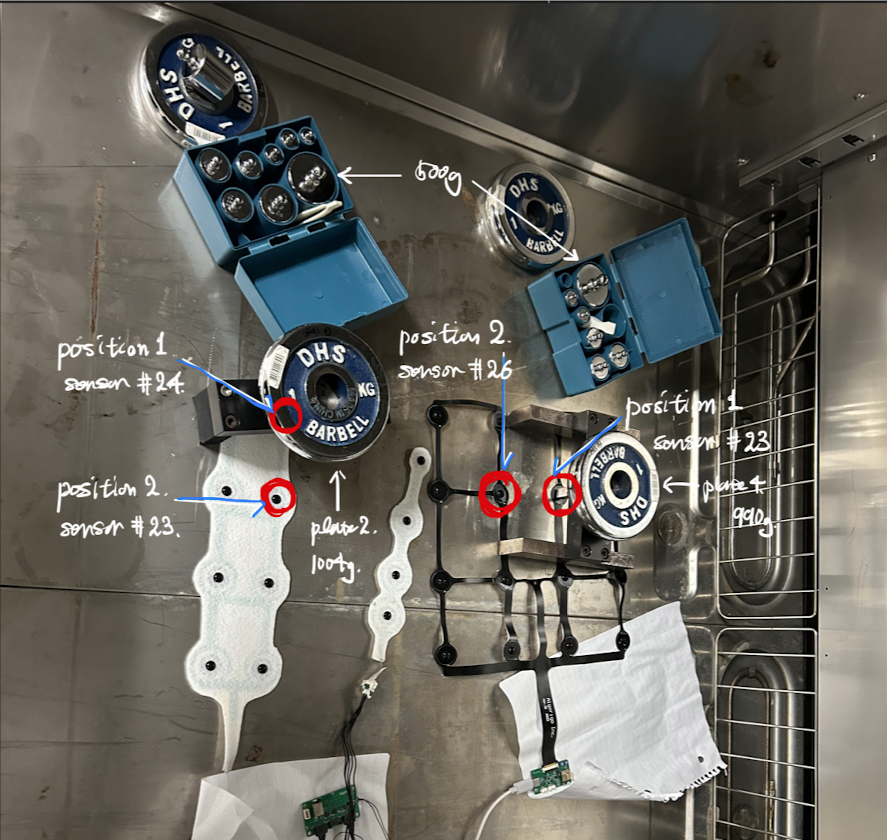

In [2]:
isLocalServer = False
sys_path_to_be_added = '/notebook/personal/ksuchoi216/temp_experiment_analysis/'
config_path = './configs/config.json'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

def checkLocalServer(isLocalServer, sys_path_to_be_added=None):
    print('='*60)
    print(f'isLocalServer is {isLocalServer}')
    print('='*60)
    
    if isLocalServer is True:
        if sys_path_to_be_added not in sys.path:
            sys.path.insert(0, sys_path_to_be_added)
            os.chdir(sys_path_to_be_added)
 
checkLocalServer(isLocalServer, sys_path_to_be_added)

!pwd
print('='*60)

isLocalServer is False
/Volumes/ssd/code/temp_experiment_analysis


In [3]:
import os
import sys

# import json
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal, interpolate

plt.rcParams['figure.figsize'] = [10, 2.5]

# os.environ['EXEC_PATH'] = os.path.abspath('.')
# sys.path.append(os.environ['EXEC_PATH'])

# from data_preproessing.lib.console.output import printc
from data_preprocessing import printc
# import lib.biosignal.signal_process.signalgo as signalgo
# import lib.biosignal.signal_process.utils as signalgo_utils

In [4]:
weights = [500, 1000, 1500]
temperatures = [-30, -15, 0, 25, 50, 80]

modified_weights_by_sensor = {
    'pressure-go.v2': {
        500: 100 + 500,        # 분동 500g
        1000: 100 + 990,       # 덤벨 1kg (plate 4) = 990g
        1500: 100 + 990 + 500  #
    },
    'transys.2021': {
        500: 250 + 500,        # 분동 500g
        1000: 250 + 1004,      # 덤벨 1kg (plate 2) = 1004g
        1500: 250 + 1004+ 500  #
    }
}

records = []
for index in range(32):
    records.append([])
# print(records)


__DATA_SET_INFO = [{
    'sensor_name': 'pressure-go.v2',
    'position': '001',
    'dir_name': '__position_001_(2,7)_(3,0)',
    'sensor_index': 23  # (2,7) = 8*2 + 7
}, {
    'sensor_name': 'pressure-go.v2',
    'position': '002',
    'dir_name': '__position_002_(3,2)_(2,7)',
    'sensor_index': 26  # (3,2) = 8*3 + 2
}, {
    'sensor_name': 'transys.2021',
    'position': '001',
    'dir_name': '__position_001_(2,7)_(3,0)',
    'sensor_index': 24 # (3,0) = 8*3 + 0
}, {
    'sensor_name': 'transys.2021',
    'position': '002',
    'dir_name': '__position_002_(3,2)_(2,7)',
    'sensor_index': 23 # (2,7) = 8*2 + 7
}]

In [5]:
def load_jsonl_df(__JSON_FILE_PATH):
    _json_list = []
    with jsonlines.open(__JSON_FILE_PATH) as f:
        for line in f.iter():
            _json_list.append(line)
    df = pd.DataFrame.from_records(_json_list)
    return df
    
def load_data(info):
    __sensor_index = info.get('sensor_index', None)
    __position = info.get('position', None)
    __dir_name = info.get('dir_name', None)
    __sensor_name = info.get('sensor_name', None)
    __postfix = '_2nd' if __position == '002' else ''
    
    __records = []
    for weight in weights:
        for temp in temperatures:
            # print(f'weight={weight} temp={temp}')
            try:
                folder_name = 'fsr22v'
                __DIR_PATH = f"./data/{folder_name}/{__dir_name}/{weight}g_{temp}{__postfix}"
                df = load_jsonl_df(f"{__DIR_PATH}/{__sensor_name}.jsonl")

                if __sensor_name == 'pressure-go.v2':
                    df_temp = df
                else:
                    df_temp = load_jsonl_df(f"{__DIR_PATH}/pressure-go.v2.jsonl")
                
                _values = np.stack(df['values'].values, axis=0)
                _mean = np.mean(_values, axis=0)
                _min = np.min(_values, axis=0)
                _max = np.max(_values, axis=0)
                _std = np.std(_values, axis=0)

                _temperature = np.stack(df_temp['temperature'].values, axis=0)
                _mean_temp = np.mean(_temperature, axis=0)

                __item = {
                    'weight': modified_weights_by_sensor[__sensor_name][weight],
                    'env_temp': temp,
                    'sensor_temp_mean': _mean_temp / 100,
                    'mean': _mean[__sensor_index],
                    'max': _max[__sensor_index],
                    'min': _min[__sensor_index],
                    'std': _std[__sensor_index]
                }
                __records.append(__item)
            except Exception as e:
                pass
                # printc(f'failde to load {__JSON_FILE_PATH}', color='red')
    return __records

for info in __DATA_SET_INFO:
    # print(info)
    sensor_name = info['sensor_name']
    position = info['position']
    print(f'{sensor_name} / {position}')
    info['records'] = load_data(info)
    
# dark backgound
sns.set_style("whitegrid") # darkgrid
# plt.style.use("dark_background") # dark_background
# sns.set_context("notebook") # paper, notebook, talk, poster
sns.set_context("notebook", font_scale = 1, rc={"grid.linewidth": 10})
sns.color_palette("tab10")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
pd.set_option("display.precision", 1)

pressure-go.v2 / 001
pressure-go.v2 / 002
transys.2021 / 001
transys.2021 / 002


## Poly Regression (temp vs FSR)

Sensor transys.2021 #24


,weight,env_temp,sensor_temp_mean,mean,max,min,std
0,750,-30,0.0,5270.4,7932,3864,254.1
1,750,-15,1.2,5059.6,6896,3408,261.6
2,750,0,8.1,5394.2,7112,3832,280.4
3,750,25,25.1,5884.4,7204,4672,209.5
4,750,50,40.4,8595.0,10664,6836,252.3
5,750,80,65.9,10398.6,11948,8712,258.9
6,1254,-30,0.0,6547.6,8588,5036,229.1
7,1254,-15,1.3,6427.1,8988,4336,236.9
8,1254,0,8.1,6627.1,8472,3132,309.1
9,1254,25,25.1,6950.3,8500,5020,245.1


25, 80 750: 0.5976860547244268
-30, 25 750: 1.2413161614813621
25, 80 1254: 0.6812458866294159
-30, 25 1254: 1.138641277341488
25, 80 1754: 0.6776883423535901
-30, 25 1754: 1.067590851138647
    averate ratio 25/80 = 0.6522067612358109


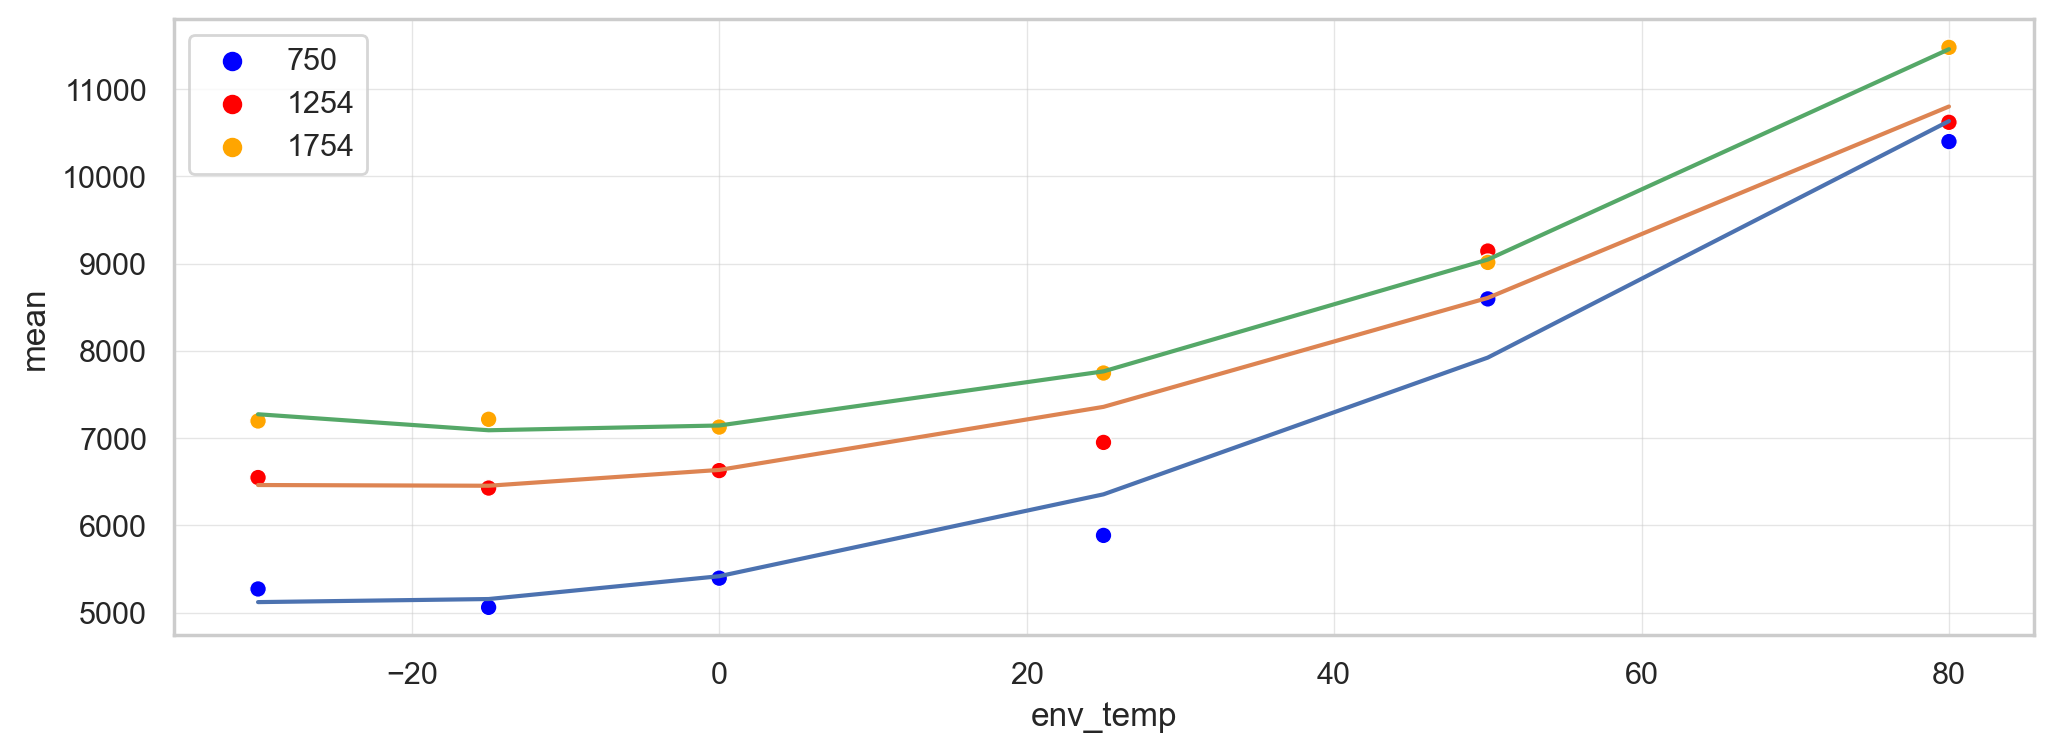

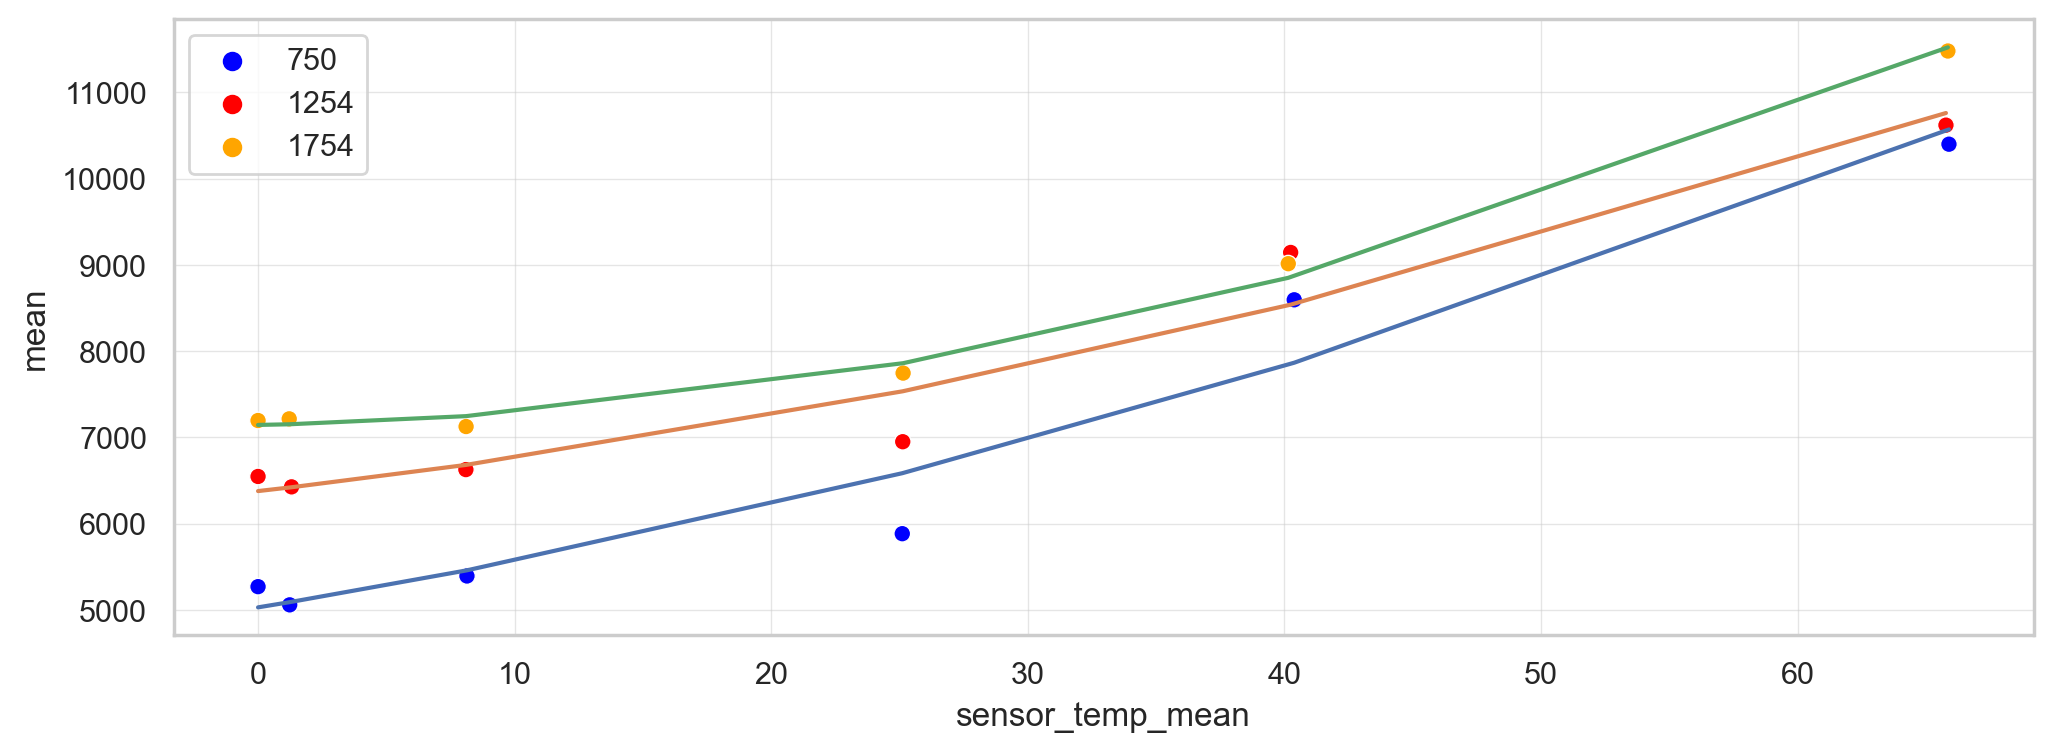

Sensor transys.2021 #23


,weight,env_temp,sensor_temp_mean,mean,max,min,std
0,750,0,8.2,4698.1,6068,3756,207.7
1,750,25,25.1,5530.0,6720,4384,217.2
2,750,50,40.5,8196.2,9916,6560,221.2
3,750,80,65.7,10838.9,12164,9888,212.7
4,1254,0,8.2,5643.7,6844,4476,214.0
5,1254,25,25.1,6005.3,8096,5276,201.3
6,1254,50,40.4,9621.8,10652,7896,197.7
7,1254,80,65.4,12521.8,12960,10476,189.0
8,1754,0,8.1,6141.3,7188,3580,223.6
9,1754,25,25.1,6178.5,7168,4784,193.5


25, 80 750: 0.5405364920703581
-30, 25 750: -1
25, 80 1254: 0.5303324848315095
-30, 25 1254: -1
25, 80 1754: 0.5684860752622604
-30, 25 1754: -1
    averate ratio 25/80 = 0.5464516840547095


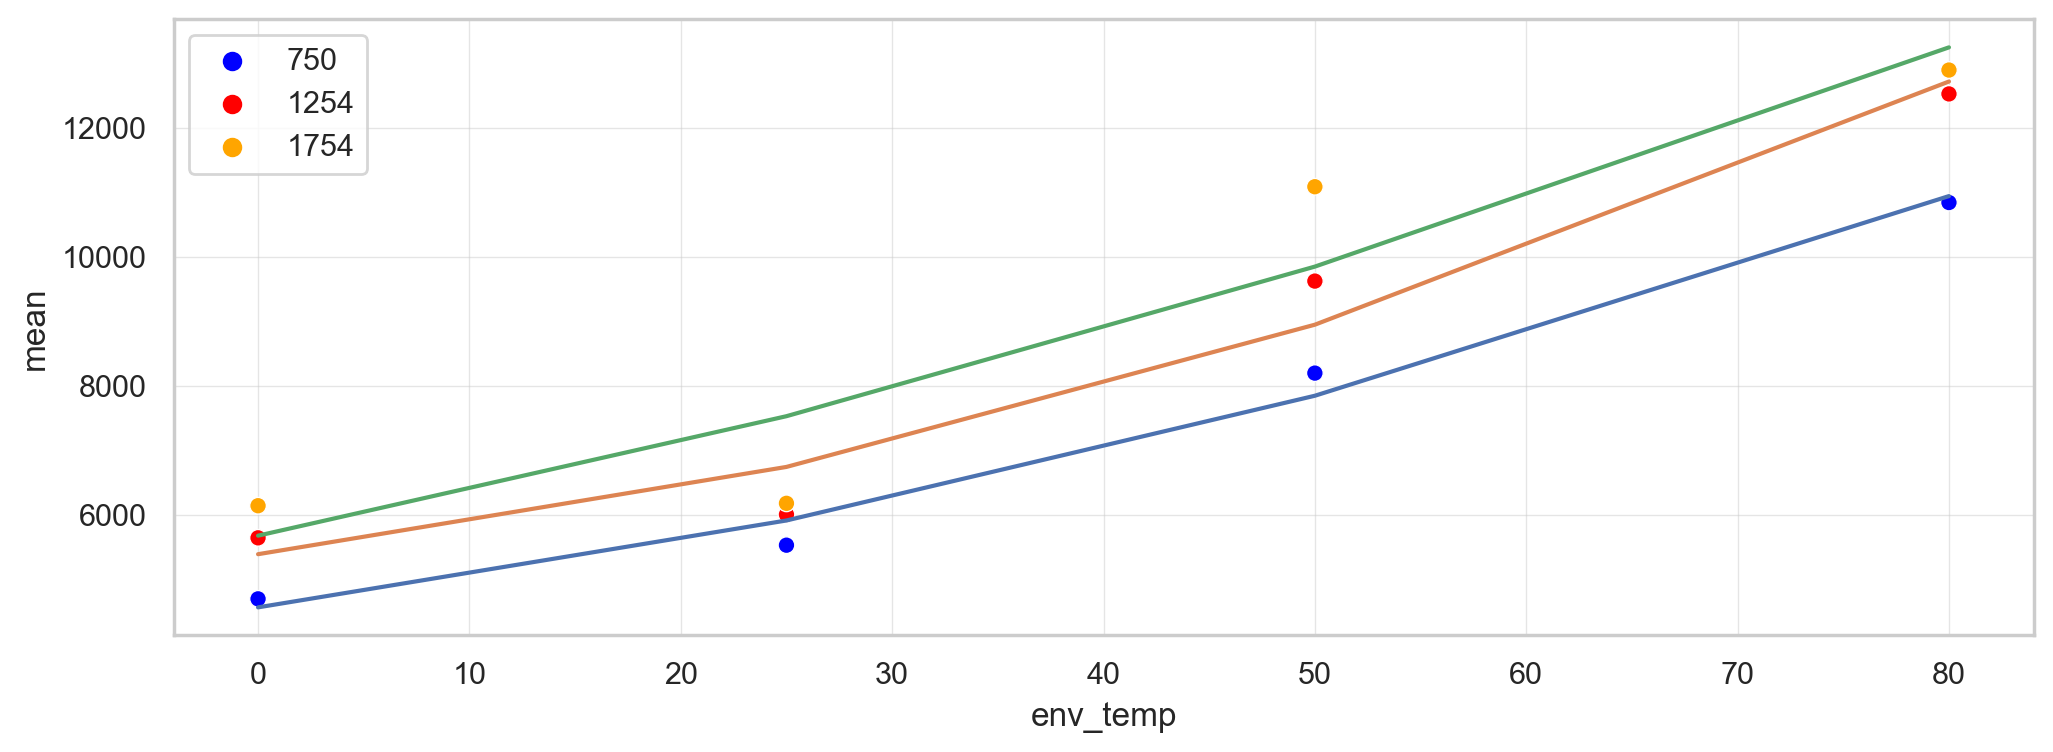

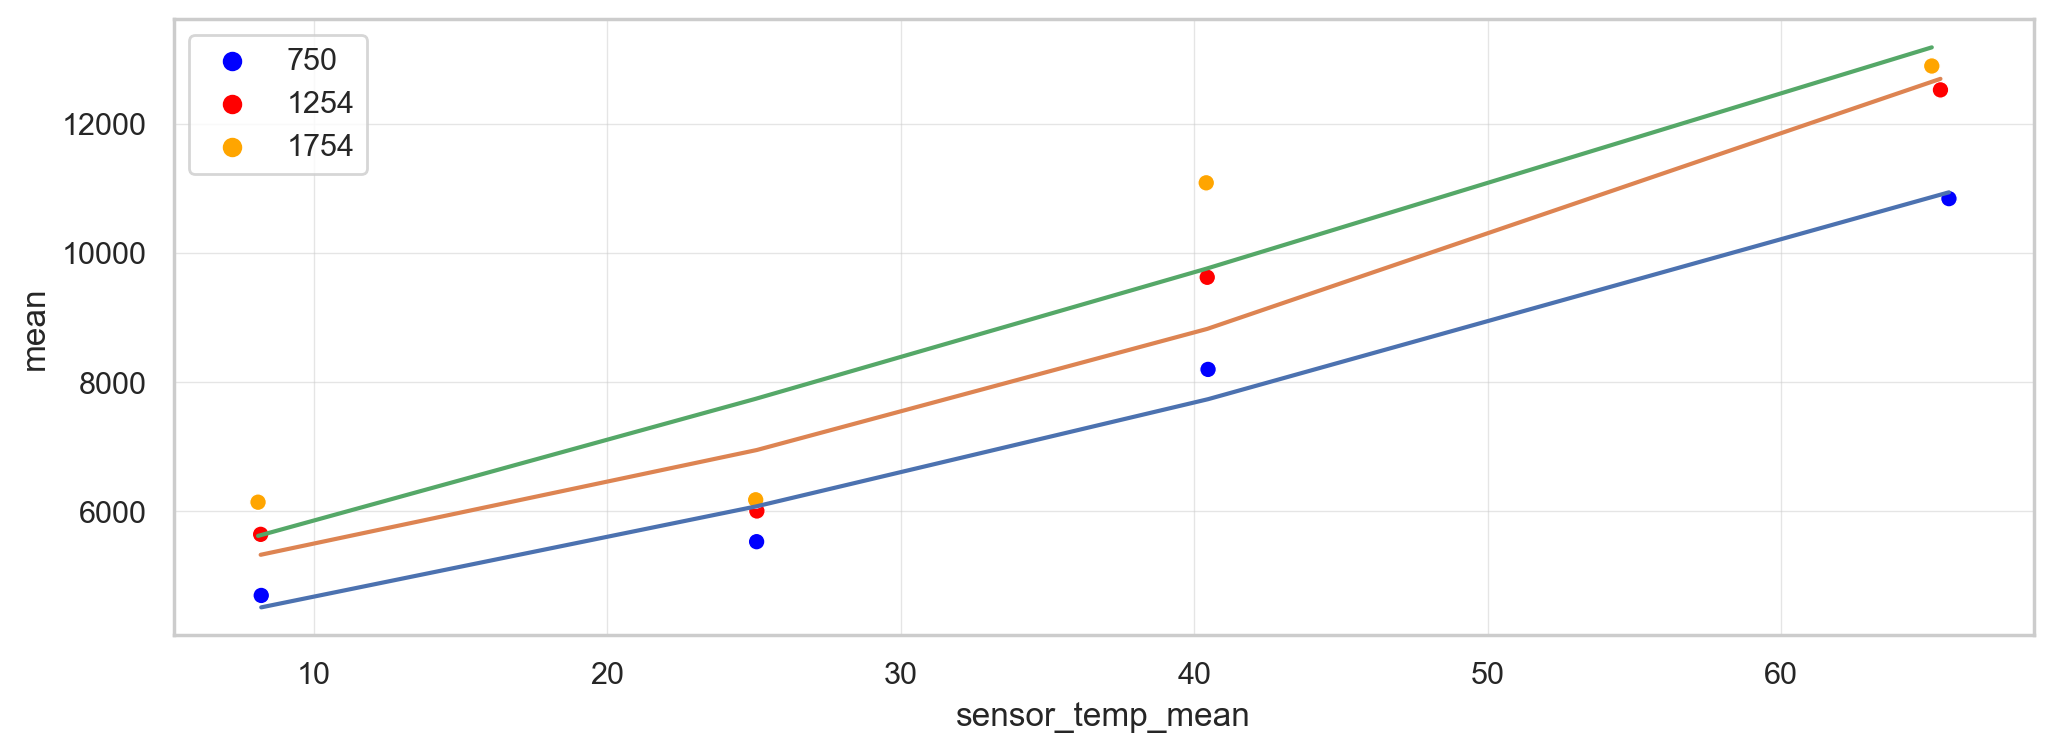

In [6]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_polynomial_regression(x, y, degree=2):
    # specifying the degree of the polynomial
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    # creating a new feature
    x_poly = poly_features.fit_transform(x.reshape(-1, 1))
    # creating a polynomial regression model
    _model = LinearRegression()
    _model.fit(x_poly, y)
    y_predicted = _model.predict(x_poly)
    return x, y_predicted, _model

def get_linear_egression(x, y):
    _model = LinearRegression()
    __x = x.reshape(-1, 1)
    _model.fit(__x, y)
    y_predicted = _model.predict(__x)
    return x, y_predicted, _model


def get_ratio(x, y, x1, x2):
    y1 = None
    y2 = None
    for _x, _y in zip(x, y):
        if _x == x1:
            y1 = _y
        if _x == x2:
            y2 = _y
        if y1 is not None and y2 is not None:
            return y1/y2
    return -1

for i, info in enumerate(__DATA_SET_INFO):
    if i in [0, 1]:
        continue
    
    printc(f"Sensor {info['sensor_name']} #{info['sensor_index']}", color='blue', style='bold')
    __df = pd.DataFrame.from_records(info['records'])
    __df.to_csv(f"stats_{info['sensor_name']}_{info['sensor_index']}.csv", index=False, encoding='utf-8')
    
    display(__df)

    plt.figure(figsize=(12,4), dpi=200)


    sns.scatterplot(x="env_temp", y="mean", hue="weight", data=__df, palette=['blue','red', 'orange'], legend='full')

    
    __ratio_list = []
    for weight in __df.weight.unique():
        _subset = __df[ __df.weight == weight]
        _x, _y, _model = get_polynomial_regression(_subset['env_temp'].values, _subset['mean'].values)
        # _x, _y, _model = get_linear_egression(_subset['env_temp'].values[2:],
                                            #   _subset['mean'].values[2:])
        __ratio = get_ratio(_x, _y, 25, 80)
        __ratio_list.append(__ratio)
        print(f"25, 80 {weight}: {__ratio}")
        __ratio = get_ratio(_x, _y, 25, -30)
        print(f"-30, 25 {weight}: {__ratio}")
        sns.lineplot(x=_x, y=_y, palette=['blue','red', 'orange'], legend='full')
    
    print(f"    averate ratio 25/80 = {np.mean(__ratio_list)}")
    
    plt.figure(figsize=(12,4), dpi=200)
    sns.scatterplot(x="sensor_temp_mean", y="mean", hue="weight", data=__df, palette=['blue','red', 'orange'], legend='full')
    
    for weight in __df.weight.unique():
        _subset = __df[ __df.weight == weight]
        _x, _y, _ = get_polynomial_regression(_subset['sensor_temp_mean'].values, _subset['mean'].values)
        sns.lineplot(x=_x, y=_y, palette=['blue','red', 'orange'], legend='full')
    
    plt.show()

## Partial Linear Regression (temp vs FSR)

Sensor transys.2021 #24


,weight,env_temp,sensor_temp_mean,mean,max,min,std
3,750,25,25.1,5884.4,7204,4672,209.5
4,750,50,40.4,8595.0,10664,6836,252.3
5,750,80,65.9,10398.6,11948,8712,258.9
9,1250,25,25.1,6950.3,8500,5020,245.1
10,1250,50,40.2,9143.9,10664,8196,222.2
11,1250,80,65.8,10619.4,12376,8980,269.0
15,1750,25,25.1,7745.6,9684,5800,244.1
16,1750,50,40.2,9013.6,10800,7544,209.0
17,1750,80,65.9,11478.5,12904,10148,260.7


,weight,env_temp,sensor_temp_mean,mean,max,min,std
0,750,-30,0.0,5270.4,7932,3864,254.1
1,750,-15,1.2,5059.6,6896,3408,261.6
2,750,0,8.1,5394.2,7112,3832,280.4
3,750,25,25.1,5884.4,7204,4672,209.5
4,750,50,40.4,8595.0,10664,6836,252.3
5,750,80,65.9,10398.6,11948,8712,258.9


LinearRegression()
[750g] ratio=[3.7134]


,weight,env_temp,sensor_temp_mean,mean,max,min,std
6,1254,-30,0.0,6547.6,8588,5036,229.1
7,1254,-15,1.3,6427.1,8988,4336,236.9
8,1254,0,8.1,6627.1,8472,3132,309.1
9,1254,25,25.1,6950.3,8500,5020,245.1
10,1254,50,40.2,9143.9,10664,8196,222.2
11,1254,80,65.8,10619.4,12376,8980,269.0


LinearRegression()
[1254g] ratio=[2.0381]


,weight,env_temp,sensor_temp_mean,mean,max,min,std
12,1754,-30,0.0,7195.9,8512,5180,235.0
13,1754,-15,1.2,7215.4,8604,5228,234.2
14,1754,0,8.1,7126.2,8608,5200,293.3
15,1754,25,25.1,7745.6,9684,5800,244.1
16,1754,50,40.2,9013.6,10800,7544,209.0
17,1754,80,65.9,11478.5,12904,10148,260.7


LinearRegression()
[1754g] ratio=[1.981]
avg ratio 80 to 25 = 0.6364
avg ratio m30 to 25 = 2.5775


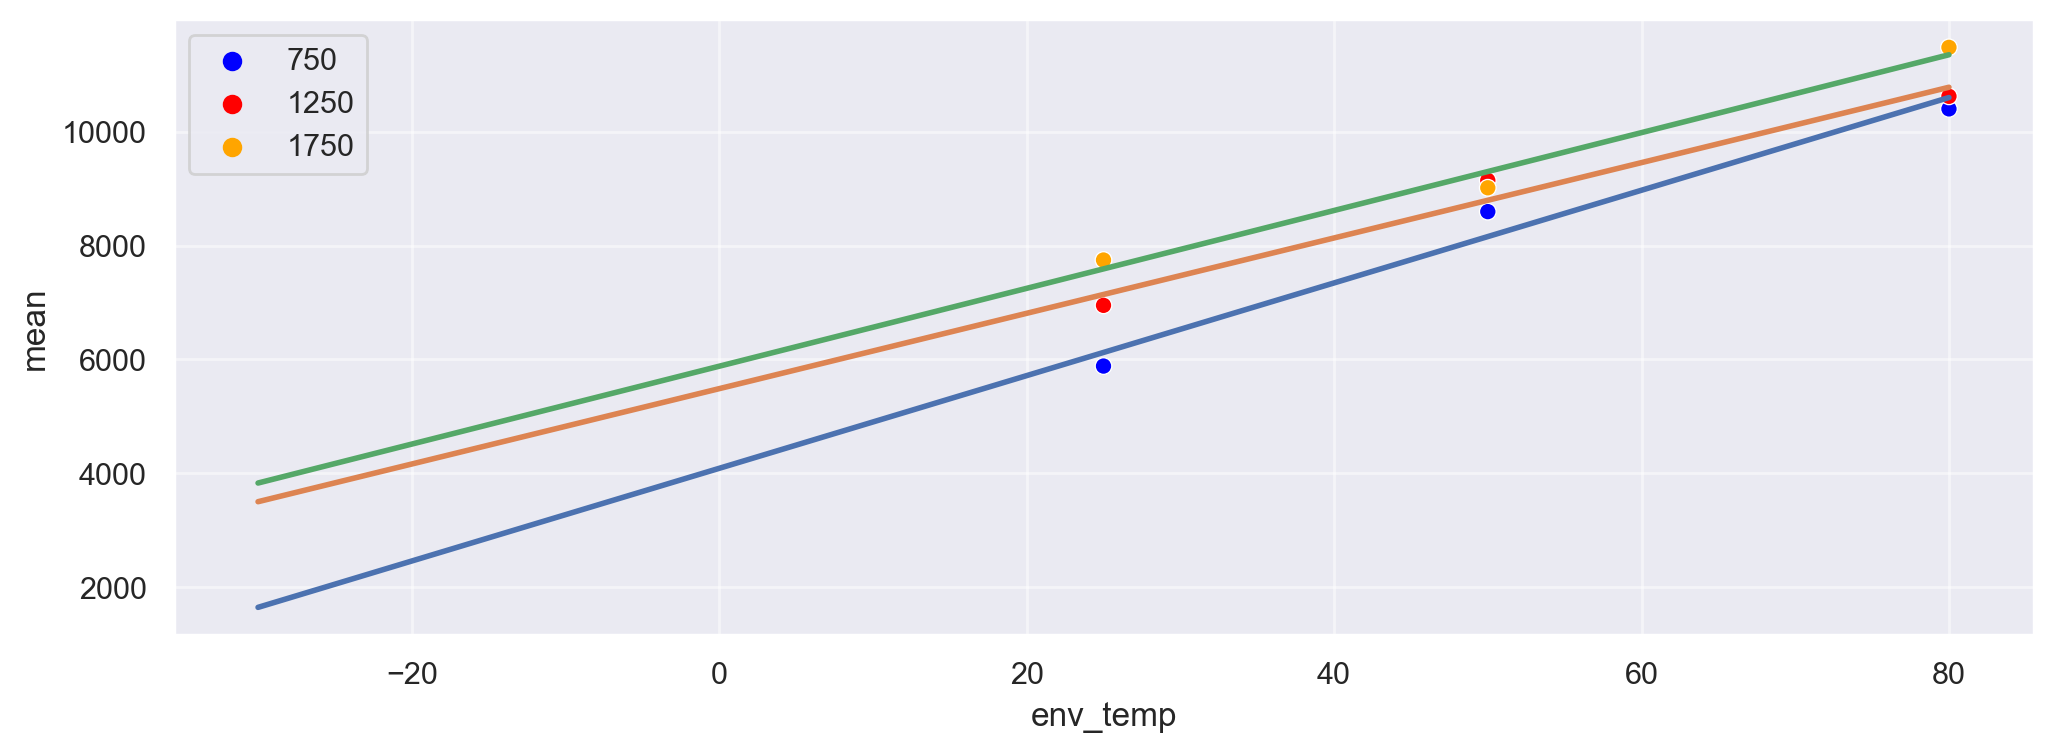

Sensor transys.2021 #23


,weight,env_temp,sensor_temp_mean,mean,max,min,std
1,750,25,25.1,5530.0,6720,4384,217.2
2,750,50,40.5,8196.2,9916,6560,221.2
3,750,80,65.7,10838.9,12164,9888,212.7
5,1250,25,25.1,6005.3,8096,5276,201.3
6,1250,50,40.4,9621.8,10652,7896,197.7
7,1250,80,65.4,12521.8,12960,10476,189.0
9,1750,25,25.1,6178.5,7168,4784,193.5
10,1750,50,40.4,11083.7,12792,9404,224.7
11,1750,80,65.1,12891.5,12964,11360,87.3


,weight,env_temp,sensor_temp_mean,mean,max,min,std
0,750,0,8.2,4698.1,6068,3756,207.7
1,750,25,25.1,5530.0,6720,4384,217.2
2,750,50,40.5,8196.2,9916,6560,221.2
3,750,80,65.7,10838.9,12164,9888,212.7


LinearRegression()
[750g] ratio=[1.]


,weight,env_temp,sensor_temp_mean,mean,max,min,std
4,1254,0,8.2,5643.7,6844,4476,214.0
5,1254,25,25.1,6005.3,8096,5276,201.3
6,1254,50,40.4,9621.8,10652,7896,197.7
7,1254,80,65.4,12521.8,12960,10476,189.0


LinearRegression()
[1254g] ratio=[1.]


,weight,env_temp,sensor_temp_mean,mean,max,min,std
8,1754,0,8.1,6141.3,7188,3580,223.6
9,1754,25,25.1,6178.5,7168,4784,193.5
10,1754,50,40.4,11083.7,12792,9404,224.7
11,1754,80,65.1,12891.5,12964,11360,87.3


LinearRegression()
[1754g] ratio=[1.]
avg ratio 80 to 25 = 1.0
avg ratio m30 to 25 = 1.0


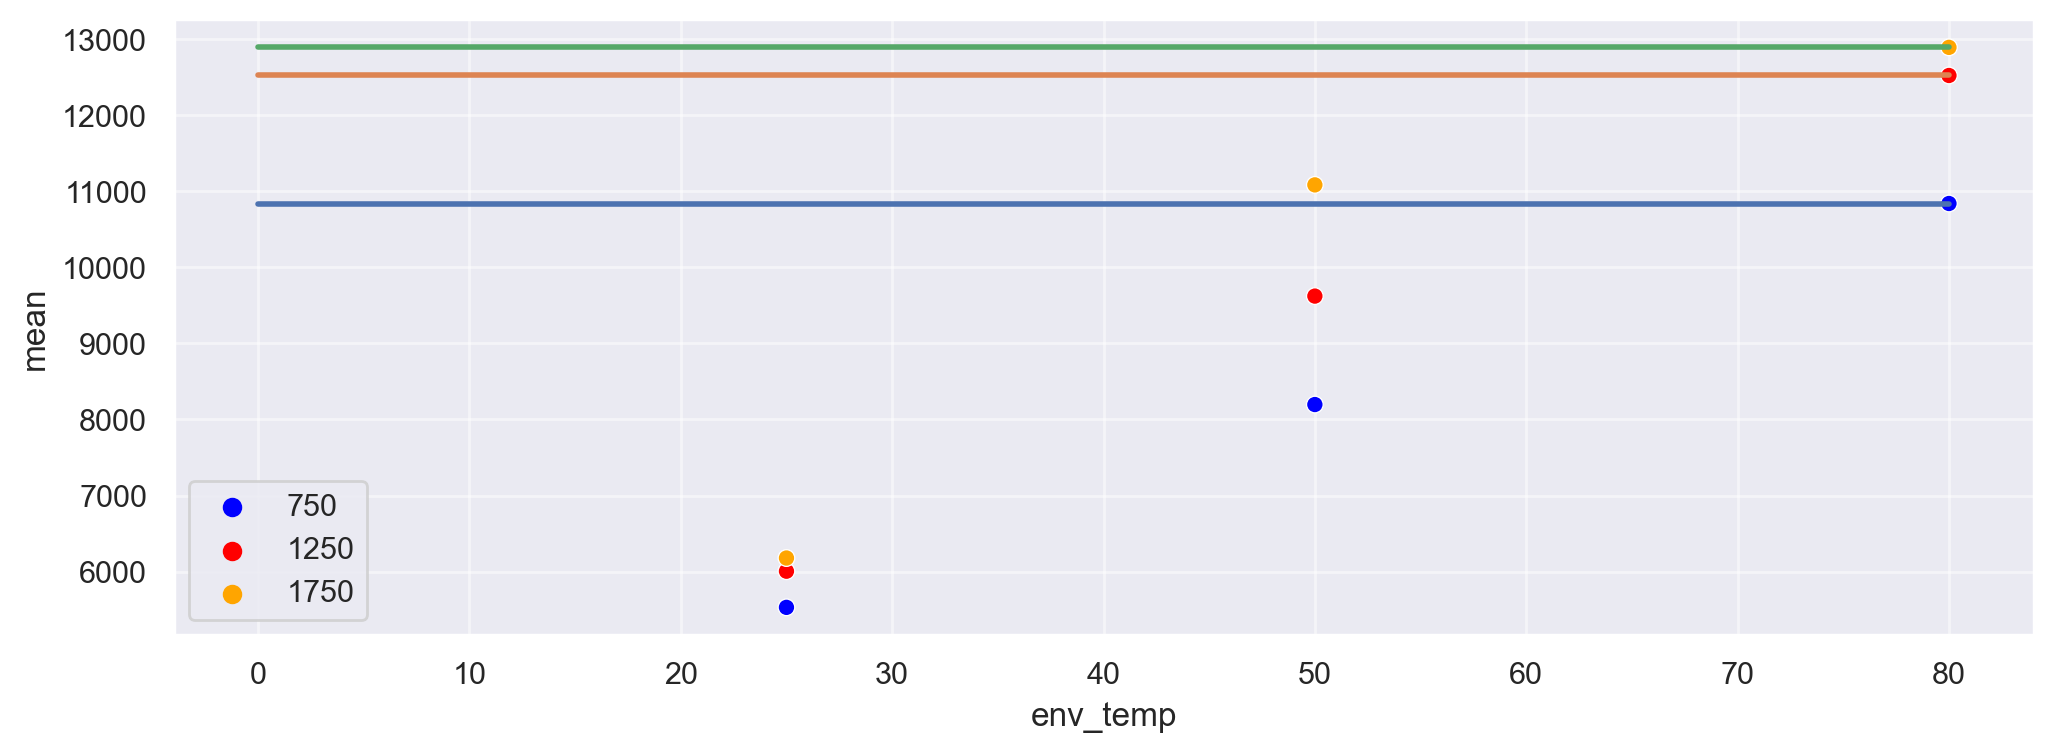

In [29]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_polynomial_regression(x, y, degree=2):
    # specifying the degree of the polynomial
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    # creating a new feature
    x_poly = poly_features.fit_transform(x.reshape(-1, 1))
    # creating a polynomial regression model
    _model = LinearRegression()
    _model.fit(x_poly, y)
    return _model

def get_linear_egression(X, y):
    _model = LinearRegression()
    _model.fit(X, y)
    
    return _model

def get_ratio(model, X_from, X_to):
    X_from = np.array(X_from).reshape(-1, 1)
    X_to = np.array(X_to).reshape(-1, 1)
    
    fsr_from = model.predict(X_from)
    fsr_to = model.predict(X_to)
    
    ratio = np.round(fsr_to / fsr_from, 4)
    return ratio


for i, info in enumerate(__DATA_SET_INFO):
    if i in [0, 1]:
        continue
    
    printc(f"Sensor {info['sensor_name']} #{info['sensor_index']}", color='blue', style='bold')
    __df = pd.DataFrame.from_records(info['records'])
    __df.to_csv(f"stats_{info['sensor_name']}_{info['sensor_index']}.csv", index=False, encoding='utf-8')
    

    plt.figure(figsize=(12,4), dpi=200)
    # display(__df)
    graph = __df[__df['env_temp']>0]

    
    graph.loc[graph['weight'] == 1254, 'weight'] = 1250
    graph.loc[graph['weight'] == 1754, 'weight'] = 1750
    display(graph)


    sns.scatterplot(x="env_temp", y="mean", hue="weight", data=graph, palette=['blue','red', 'orange'], legend='full')

    
    ratio_80to25 = []
    ratio_m30to25 = []
    for weight in __df.weight.unique():
        _subset = __df[ __df.weight == weight]
        display(_subset)
        
        X_train = _subset['env_temp'].values[3:].reshape(-1, 1)
        y_train = _subset['mean'].values[3:]
        
        _model = get_linear_egression(X_train, y_train)
        print('model intercept: ', _model.intercept)
        print('model R^2: ', model.score(X_train, y_train))
        
        X_test = _subset['env_temp'].values.reshape(-1, 1)
        y_pred = _model.predict(X_test)
        X_test = X_test.reshape(-1)
        
        ratio = get_ratio(_model, X_from = 80, X_to = 25)
        ratio_80to25.append(ratio)
        
        ratio = get_ratio(_model, X_from = -30, X_to = 25)
        ratio_m30to25.append(ratio)
        
        
        print(f'[{weight}g] ratio={ratio}')
        # print(f"25, 80 {weight}: {__ratio}")
        # print(f"-30, 25 {weight}: {__ratio}")
        # sns.scatterplot(x="env_temp", y="mean", hue="weight", data=__df, palette=['blue','red', 'orange'], legend='full')
        sns.lineplot(x=X_test, y=y_pred, palette=['blue','red', 'orange'], legend='full')
    
    
    print(f"avg ratio 80 to 25 = {np.round(np.mean(ratio_80to25),4)}")
    print(f"avg ratio m30 to 25 = {np.round(np.mean(ratio_m30to25),4)}")
    
    # plt.figure(figsize=(12,4), dpi=200)
    # sns.scatterplot(x="sensor_temp_mean", y="mean", hue="weight", data=__df, palette=['blue','red', 'orange'], legend='full')
    
    # for weight in __df.weight.unique():
    #     _subset = __df[ __df.weight == weight]
    #     _x, _y, _ = get_polynomial_regression(_subset['sensor_temp_mean'].values, _subset['mean'].values)
    #     sns.lineplot(x=_x, y=_y, palette=['blue','red', 'orange'], legend='full')
    
    plt.show()
    
    
    
    

## weight - sensor value graph

In [ ]:
for info in __DATA_SET_INFO:
    printc(f"Sensor {info['sensor_name']} #{info['sensor_index']}", color='blue', style='bold')
    out_box1 = widgets.Output()
    out_box2 = widgets.Output()
    __df = pd.DataFrame.from_records(info['records'])
    __df.to_csv(f"stats_{info['sensor_name']}_{info['sensor_index']}.csv", index=False, encoding='utf-8')
    with out_box1:     
        display(__df)
    with out_box2:
        plt.figure(figsize=(12,4), dpi=200)
        sns.scatterplot(x="weight", y="mean", hue="env_temp", data=__df, legend='full')
        
        print(' ', __df.env_temp.unique())
        for env_temp in __df.env_temp.unique():
            _subset = __df[ __df.env_temp == env_temp]
#             _x, _y, _ = get_linear_egression(_subset['weight'].values, _subset['mean'].values)
#             sns.lineplot(x=_x, y=_y, legend='full')
            _x, _y, _model = get_polynomial_regression(_subset['weight'].values, _subset['mean'].values)
            sns.lineplot(x=_x, y=_y, legend='full')
        
#         plt.figure(figsize=(12,4), dpi=200)
#         sns.scatterplot(x="sensor_temp_mean", y="mean", hue="weight", data=__df, palette=['blue','red', 'orange'], legend='full')
        
#         for weight in __df.weight.unique():
#             _subset = __df[ __df.weight == weight]
#             _x, _y, _ = get_polynomial_regression(_subset['sensor_temp_mean'].values, _subset['mean'].values)
#             sns.lineplot(x=_x, y=_y, palette=['blue','red', 'orange'], legend='full')
        
        plt.show()

    grid = GridspecLayout(10, 10)
    grid[:, 0:3] = out_box1
    grid[:, 3:10] = out_box2
    display(grid)

Sensor pressure-go.v2 #23


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Sensor pressure-go.v2 #26


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Sensor transys.2021 #24


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Sensor transys.2021 #23


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…